In [2]:
import pandas as pd
import numpy as np
import sys
import os
import itertools
import time
import random

#import utils
sys.path.insert(0, '../utils/')
from utils_preprocess_v3 import *
from utils_modeling_v9 import *
from utils_plots_v2 import *

#sklearn
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

start_time = time.time()

# load datasets

In [3]:
data = pd.read_csv('../data/datasets_processed/Harel_PD1_data.csv', index_col='Unnamed: 0')
response = pd.read_csv('../data/datasets_processed/Harel_PD1_response.csv', index_col='Unnamed: 0')
interactome = pd.read_csv('../data/interactomes/inbiomap_processed.txt', sep = '\t')

# preprocess

In [4]:
# get nodes from data and graph
data_nodes = data['node'].tolist()
interactome_nodes = list(set(np.concatenate((interactome['node1'], interactome['node2']))))

# organize data
organize = Preprocessing()
save_location = '../data/reduced_interactomes/reduced_interactome_Harel_PD1.txt'
organize.transform(data_nodes, interactome_nodes, interactome, data, save_location, load_graph = True)

In [5]:
# extract info from preprocessing
X = organize.sorted_X.T.values
y = response.values.reshape(-1,1)
L_norm = organize.L_norm
L = organize.L

g = organize.g
num_to_node = organize.num_to_node

# split for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12)

# scaling X
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# scalying y
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train).reshape(-1)
y_test = scaler_y.transform(y_test).reshape(-1)

In [6]:
# define training params
alpha_list = np.logspace(-1,0,15)
threshold_list = np.logspace(-3,-1,10)
max_features = 10

# Lasso 

In [6]:
VanillaLasso = LaplacianRegression('Lasso')
VanillaLasso.fit(X_train, y_train, X_test, y_test, alpha_list, threshold_list, L = None, 
                  max_features = max_features, solver = cp.ECOS, force_features = True, verbose = False)

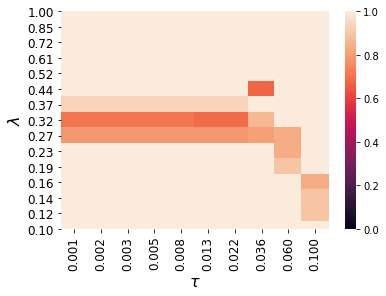

In [7]:
VanillaLasso.plotgridsearch()

In [8]:
print('Test MSE : ' ,VanillaLasso.predict(X_test, y_test))

Test MSE :  0.6721839373283401


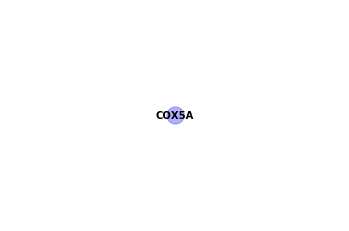

In [9]:
getTranslatedNodes(VanillaLasso.feats_, VanillaLasso.regr_.coef_, num_to_node, g,)

# NTF-Lasso

In [14]:
NTFLasso = LaplacianRegression('Lasso')
NTFLasso.fit(X_train, y_train, X_test, y_test, alpha_list, threshold_list, L = L_norm, 
                  max_features = max_features, solver = cp.SCS, force_features = True, verbose = False)

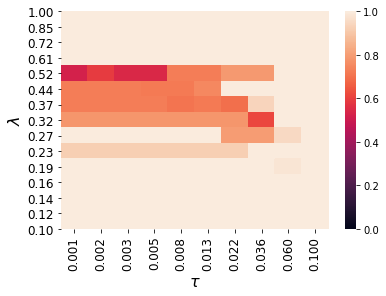

In [15]:
NTFLasso.plotgridsearch()

In [16]:
print('Test MSE : ' ,NTFLasso.predict(X_test, y_test))

Test MSE :  0.5262284411698149


/home/gokamath/anaconda3/envs/py373/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


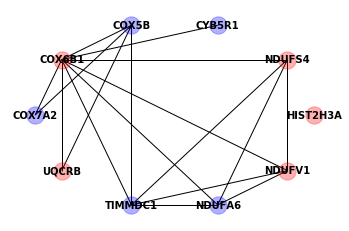

In [18]:
getTranslatedNodes(NTFLasso.feats_, NTFLasso.regr_.coef_, num_to_node, g,)

# Ridge

In [19]:
VanillaRidge = LaplacianRegression('Ridge')
VanillaRidge.fit(X_train, y_train, X_test, y_test, alpha_list, threshold_list, L = None, 
                  max_features = max_features, solver = cp.ECOS, force_features = True, verbose = False)

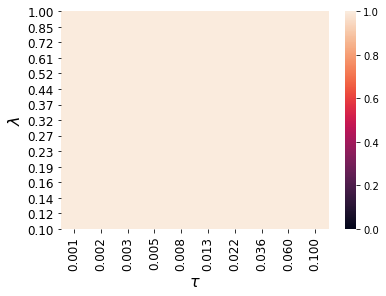

In [20]:
VanillaRidge.plotgridsearch()

In [21]:
print('Test MSE : ' ,VanillaRidge.predict(X_test, y_test))

Test MSE :  1.5149717664397242


/home/gokamath/anaconda3/envs/py373/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


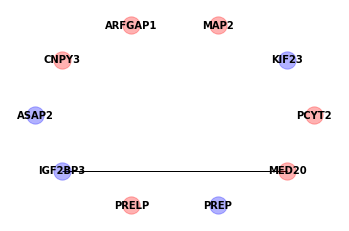

In [22]:
getTranslatedNodes(VanillaRidge.feats_, VanillaRidge.regr_.coef_, num_to_node, g,)

# NTF-Ridge

In [27]:
NTFRidge = LaplacianRegression('Ridge')
NTFRidge.fit(X_train, y_train, X_test, y_test, alpha_list, threshold_list, L = L_norm, 
                  max_features = max_features, solver = cp.SCS, force_features = True, verbose = False)

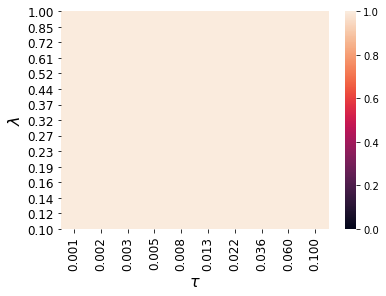

In [28]:
NTFRidge.plotgridsearch()

In [29]:
print('Test MSE : ' ,NTFRidge.predict(X_test, y_test))

Test MSE :  1.415053575591604


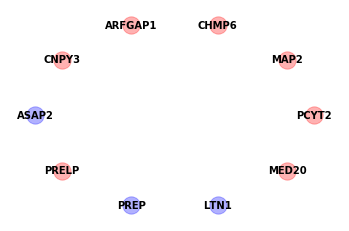

In [31]:
getTranslatedNodes(NTFRidge.feats_, NTFRidge.regr_.coef_, num_to_node, g,)

# TF-Lasso (Graph TF)

In [32]:
TFLasso = LaplacianRegression('Lasso')
TFLasso.fit(X_train, y_train, X_test, y_test, alpha_list, threshold_list, L = L, 
                  max_features = max_features, solver = cp.SCS, solver_params = {'max_iters' : 10000},
                  force_features = True, verbose = False)

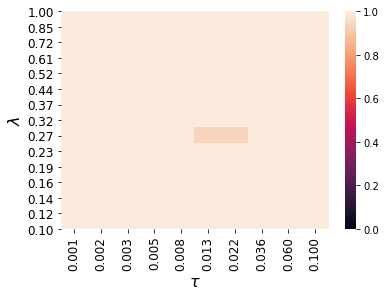

In [33]:
TFLasso.plotgridsearch()

In [34]:
print('Test MSE : ' ,TFLasso.predict(X_test, y_test))

Test MSE :  0.9405716301448434


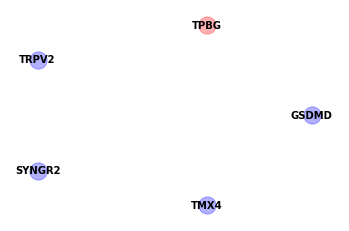

In [35]:
getTranslatedNodes(TFLasso.feats_, TFLasso.regr_.coef_, num_to_node, g,)

# Nonconvex Penalties (MCP, SCAD)

Training is over.
Test MSE :  0.6684313059518149


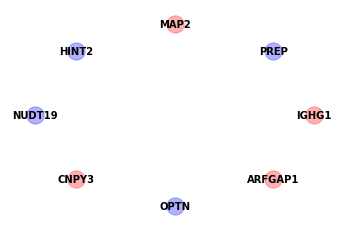

In [161]:
MCP = NonConvexRegression(penalty ='mcp')
MCP.fit(X_train, y_train, X_train, y_train, X_test, y_test, alpha_list, threshold_list, max_features = max_features, force_features = True)
print('Test MSE : ' ,MCP.predict(X_test, y_test))
getTranslatedNodes(MCP.feats_, MCP.regr_.coef_, num_to_node, g, save_location = '../figures/PD1_MCP.png')

Training is over.
Test MSE :  0.6721839373283401


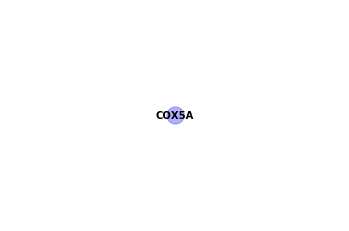

In [162]:
SCAD = NonConvexRegression(penalty = 'scad')
SCAD.fit(X_train, y_train, X_train, y_train, X_test, y_test, alpha_list, threshold_list, max_features = max_features, force_features = True)
print('Test MSE : ' ,SCAD.predict(X_test, y_test))
getTranslatedNodes(SCAD.feats_, SCAD.regr_.coef_, num_to_node, g, save_location = '../figures/PD1_SCAD.png')

# NTF-Nonconvex Penalties (NTF-MCP, NTF-SCAD) 

In [167]:
L_norm_dagger = scipy.linalg.pinv(L_norm.todense())
X_train_new =  X_train.dot(L_norm_dagger)
X_test_new = X_test.dot(L_norm_dagger) 

Training is over.
Test MSE :  0.7928155773822746


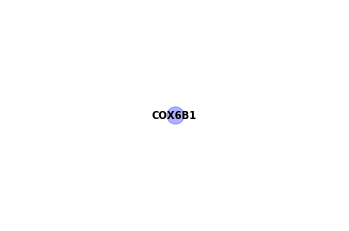

In [168]:
NTFMCP = NonConvexRegression(penalty ='mcp')
NTFMCP.fit(X_train_new, y_train, X_train, y_train, X_test, y_test, 
           alpha_list, threshold_list, max_features = max_features, force_features = True)
print('Test MSE : ' ,NTFMCP.predict(X_test, y_test))
getTranslatedNodes(NTFMCP.feats_, NTFMCP.regr_.coef_, num_to_node, g, save_location = '../figures/PD1_NTF-MCP.png')

Training is over.
Test MSE :  0.3234589229075096


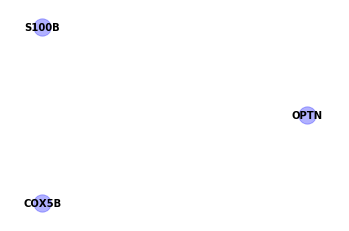

In [169]:
NTFSCAD = NonConvexRegression(penalty ='scad')
NTFSCAD.fit(X_train_new, y_train, X_train, y_train, X_test, y_test, 
            alpha_list, threshold_list, max_features = max_features, force_features = True)
print('Test MSE : ' ,NTFSCAD.predict(X_test, y_test))
getTranslatedNodes(NTFSCAD.feats_, NTFSCAD.regr_.coef_, num_to_node, g, save_location = '../figures/PD1_NTF-SCAD.png')

# asdasda

In [196]:
def loss_fn(X,Y, L, alpha1, alpha2, beta):
    return 0.5/(len(X)) * cp.norm2(cp.matmul(X, beta) - Y)**2 + \
           alpha1 * cp.norm1(beta) + \
           alpha2 * cp.sum(cp.quad_form(beta,L)) 

alpha1_list = np.logspace(-1,0,15)
alpha2_list = np.logspace(-1,2,15)
alpha_pairs = list(itertools.product(alpha1_list, alpha2_list))

def run(pair):
    beta = cp.Variable(X_train.shape[1])
    alpha1 = cp.Parameter(nonneg=True)
    alpha2 = cp.Parameter(nonneg=True)
    alpha1.value = pair[0]
    alpha2.value = pair[1]
    
    problem = cp.Problem(cp.Minimize(loss_fn(X_train, y_train, L_norm, alpha1, alpha2, beta )))
    problem.solve(solver = cp.SCS, verbose = True)

    return beta.value

In [197]:
betas = Parallel(n_jobs=75, verbose = True)(delayed(run)(pair) for pair in alpha_pairs)

[Parallel(n_jobs=75)]: Using backend LokyBackend with 75 concurrent workers.
[Parallel(n_jobs=75)]: Done  50 tasks      | elapsed: 42.0min
[Parallel(n_jobs=75)]: Done 225 out of 225 | elapsed: 125.8min finished


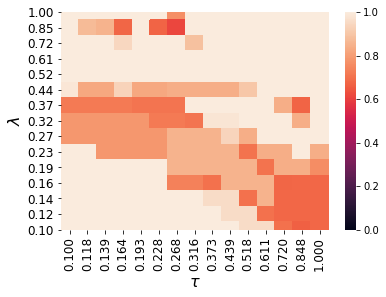

In [228]:
feats = [getFeatures(None, i, threshold=0.001, max_features=10) for i in betas]
regr = LinearRegression()
scores = [getScoring(regr, X_train, y_train, X_test, y_test, i, None) for i in feats]
train_scores = [i[0] for i in scores]
test_scores = [i[1] for i in scores]
gridsearch_results = pd.DataFrame(np.array(test_scores), columns = ['Test MSE'])
getGridsearchPlot(gridsearch_results, alpha_list, alpha_list, save_location = None)

In [229]:
min(test_scores)

0.61593483855938

In [230]:
np.where(test_scores == min(test_scores))

(array([201]),)

/home/gokamath/anaconda3/envs/py373/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


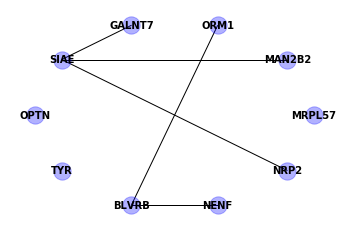

In [232]:
getTranslatedNodes(feats[201], [1,1,1,1,1,1,1,1,1,1,1,1,1,1], num_to_node, g)

# Shuffled Features

In [150]:
# scramble feature order
random.seed(16)
feat_idx = list(range(X.shape[1]))
random.shuffle(feat_idx)
X_shuf = deepcopy(X[:,feat_idx])

# split for training
X_train, X_test, y_train, y_test = train_test_split(X_shuf, y, test_size=0.20, random_state=12)

# scaling X
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# scalying y
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train).reshape(-1)
y_test = scaler_y.transform(y_test).reshape(-1)

In [204]:
ShuffledNTFLasso = LaplacianRegression('Lasso')
ShuffledNTFLasso.fit(X_train, y_train, X_test, y_test, alpha_list, threshold_list, L = L_norm, 
                  max_features = max_features, solver = cp.SCS, force_features = True, verbose = False)

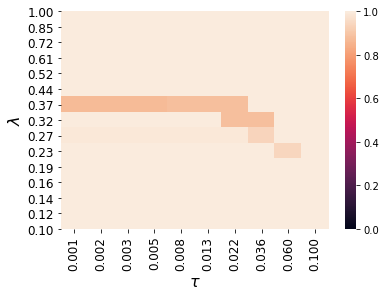

In [205]:
ShuffledNTFLasso.plotgridsearch()

In [206]:
print('Test MSE : ' ,ShuffledNTFLasso.predict(X_test, y_test))

Test MSE :  0.8739075547196012


/home/gokamath/anaconda3/envs/py373/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


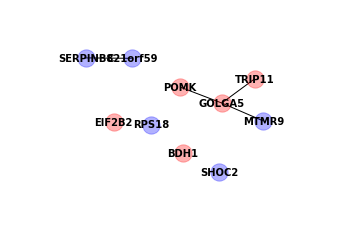

In [207]:
getTranslatedNodes(ShuffledNTFLasso.feats_, ShuffledNTFLasso.regr_.coef_, num_to_node, g,)

Training is over.
Test MSE :  1.1987566499762399


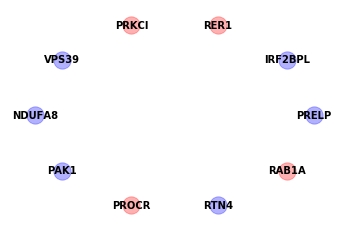

Training is over.
Test MSE :  0.7115320663242739


/home/gokamath/anaconda3/envs/py373/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


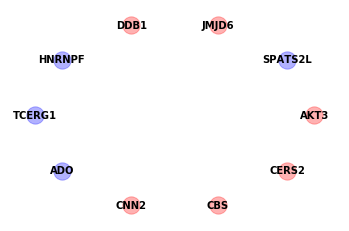

In [151]:
X_train_new =  X_train.dot(L_norm_dagger)
X_test_new = X_test.dot(L_norm_dagger) 

ShuffledNTFMCP = NonConvexRegression(penalty ='mcp')
ShuffledNTFMCP.fit(X_train_new, y_train, X_train, y_train, X_test, y_test, 
           alpha_list, threshold_list, max_features = max_features, force_features = True)
print('Test MSE : ' ,ShuffledNTFMCP.predict(X_test, y_test))
getTranslatedNodes(ShuffledNTFMCP.feats_, ShuffledNTFMCP.regr_.coef_, num_to_node, g,)

ShuffledNTFSCAD = NonConvexRegression(penalty ='scad')
ShuffledNTFSCAD.fit(X_train_new, y_train, X_train, y_train, X_test, y_test,
                    alpha_list, threshold_list, max_features = max_features, force_features = True)
print('Test MSE : ' ,ShuffledNTFSCAD.predict(X_test, y_test))
getTranslatedNodes(ShuffledNTFSCAD.feats_, ShuffledNTFSCAD.regr_.coef_, num_to_node, g,)


#### Elapsed time

In [208]:
print( 'Elapsed Time : ', time.time() - start_time)

Elapsed Time :  20478.556378126144
